TODO:
MLP
○ Data analysis
○ Data preprocessing and normalization
○ Data split
○ Configuration
○ Experiment tracking
○ Experiments - meaningful based on the results of previous experiments
    ■ Including improvement techniques (e.g. Dropout, Normalization layers, Skip
    Connections, Bottleneck Layers, …)
○ Hyperparameter search (grid/random) / sweep     #optional
○ Results and evaluation metrics
○ Clear code
○ Markdown documentation and comments
○ Final presentation of projects
○ Effort on consultations


OUR TODO:
download dataset using pandas ? easier because of we can just use link but maybe everyone will use pandas 
good enough data analysis that is seen in jupyter notebook, not just from reading dataset
correlation chart  -  chart of correlation of columns between themselves

imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas as pd

dataset

In [2]:


df = pd.read_csv("dataset.csv")

print(":white_check_mark: File uploaded!. Size:", df.shape)
display(df.head())

:white_check_mark: File uploaded!. Size: (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


data analysis with nice graphs and chart of correlations

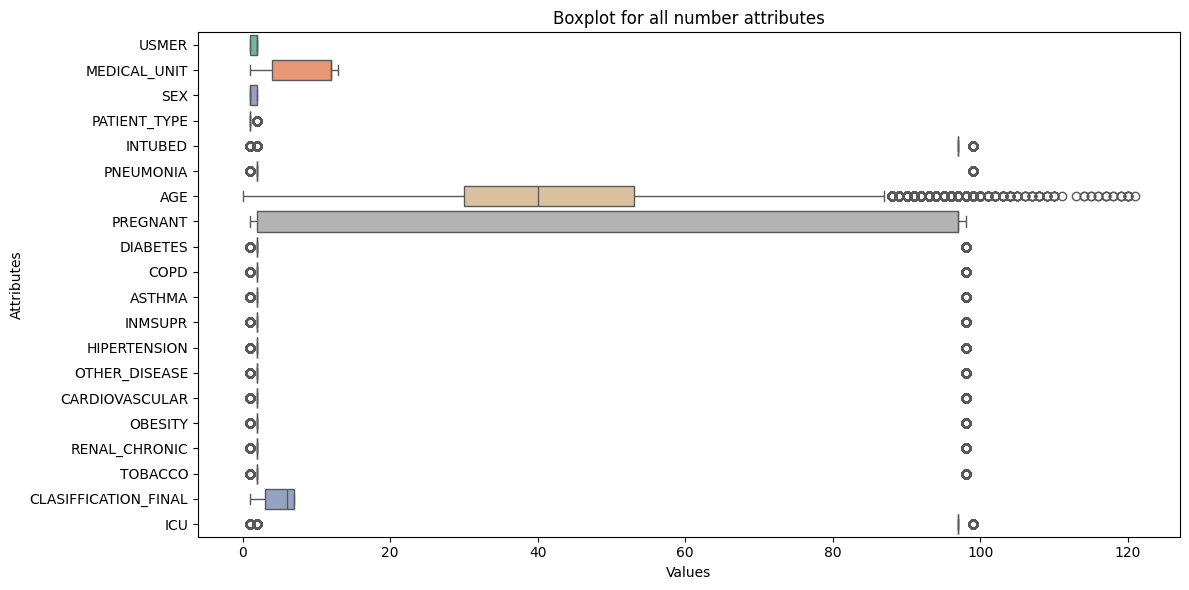

In [ ]:


numeric_df = df.select_dtypes(include=["number"])

if numeric_df.empty:
    print("No number attrs for boxplot.")
else:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=numeric_df, orient="h", palette="Set2")
    plt.title("Boxplot for all number attributes")
    plt.xlabel("Values")
    plt.ylabel("Attributes")
    plt.tight_layout()
    plt.show()
    


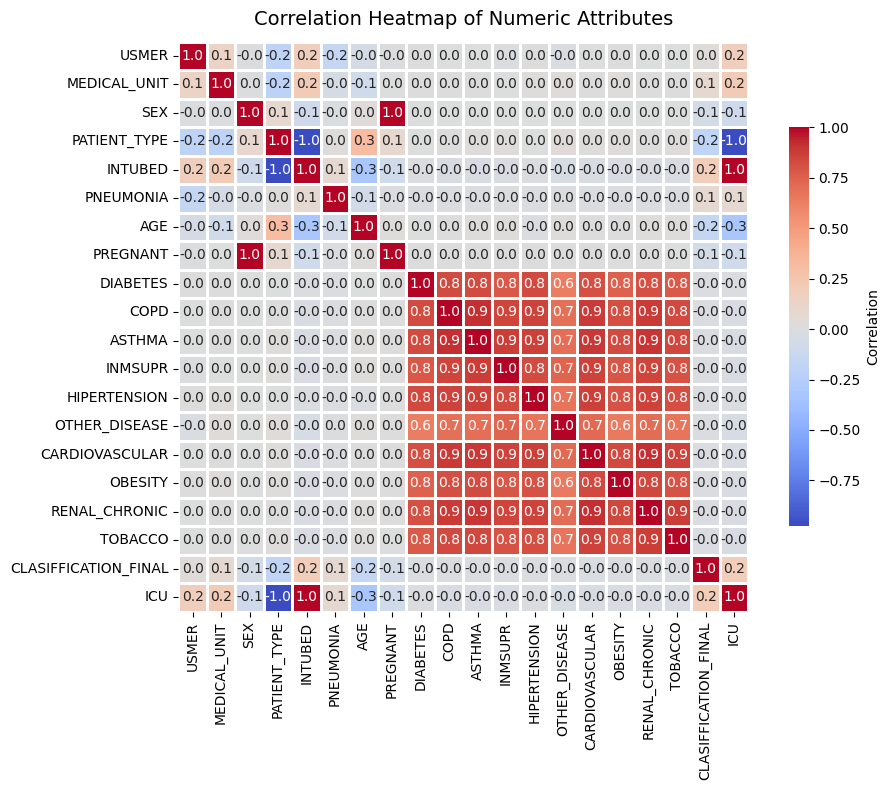

In [5]:
numeric_df = df.select_dtypes(include=["number"])

if numeric_df.empty:
    print("No numeric attributes found in this dataset.")
else:
    corr = numeric_df.corr()

    plt.figure(figsize=(10, 8))

    sns.heatmap(
        corr,
        annot=True,         # Show correlation values
        cmap="coolwarm",    # Color palette
        fmt=".1f",          # Format numbers to 1
        square=True,        # Make cells square
        linewidths=1,     # Add thin lines between cells
        cbar_kws={"shrink": 0.7, "label": "Correlation"}
    )

    plt.title("Correlation Heatmap of Numeric Attributes", fontsize=14, pad=12)
    plt.tight_layout()
    plt.show()

data preprocessing and normalization